# Advanced ML: Домашнее задание 1

Это задание связано с анализом конкретного датасета, в котором, надеюсь, понадобится то, чему мы с вами до сих пор научились. В качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему в этом ноутбуке категорически приветствуются. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:
https://ourworldindata.org/coronavirus-source-data

## 1. Данные

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (11,6)
legend_fontsize = 16

In [2]:
data_all = pd.read_csv("owid-covid-data.csv")
data_russia = data_all[(data_all.location == "Russia") & (data_all.date >= "2020-03-01")].reset_index(drop=True)
data_russia.loc[data_russia.new_cases == 0, 'new_cases'] = 1.
train, test = data_russia.iloc[:50], data_russia.iloc[50:]

## 2. Экспоненциальная модель

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

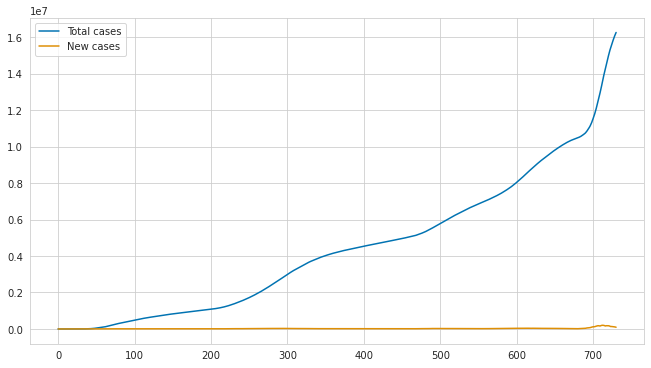

In [3]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(data_russia.total_cases, label="Total cases")
ax.plot(data_russia.new_cases, label="New cases")
ax.legend();

### 2.a Линейная регрессия

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

Для простоты вычислений вместо взятия экспоненты прологарифмируем, получаем ln y ~ линейная функция от x

In [4]:
train_features = train.index.values[:, None]
train_targets = np.log(train.total_cases).values

test_features = test.index.values[:, None]
test_targets = np.log(test.total_cases).values

reg = LinearRegression()
reg.fit(train_features, train_targets)

train_pred = reg.predict(train_features)
test_pred = reg.predict(test_features)

На обучающей выборке достигается неплохое качество

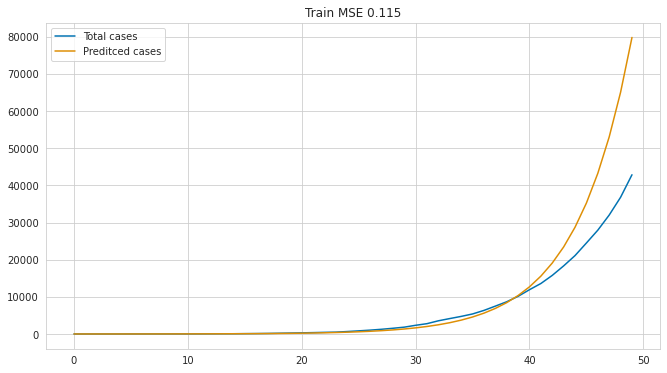

In [5]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(train.total_cases, label="Total cases")
ax.plot(np.exp(train_pred), label="Preditced cases")
ax.set_title(f"Train MSE {mean_squared_error(train_targets, train_pred).round(4)}")
ax.legend();

Однако на тестовой выборке видно, что полученная модель обладает плохой способностью к экстраполяции

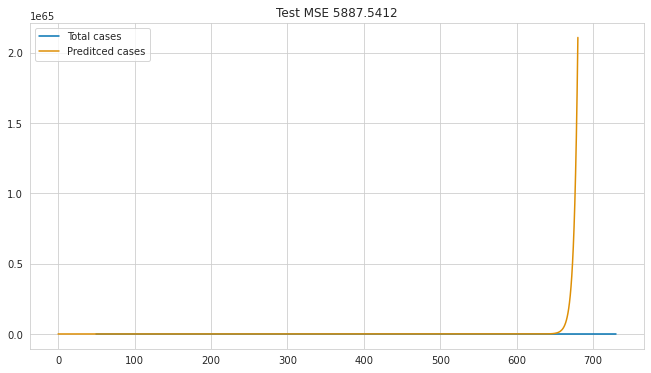

In [6]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(test.total_cases, label="Total cases")
ax.plot(np.exp(test_pred), label="Preditced cases")
ax.set_title(f"Test MSE {mean_squared_error(test_targets, test_pred).round(4)}")
ax.legend();

## 2.b Апостериорное распределение параметров модели

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

В качестве априорного распределения параметров модели возьмем нормальное распределение с средним 0 и ско 5

In [7]:
def bayesian_update(mu: np.ndarray, sigma: np.array, x: float, y: float, sigma_noise=.25):
    '''Шаг обновления байесовского вывода'''
    x_matrix =  np.append(1, np.array(x))[None, :]
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    
    return mu_n, sigma_n


def bayesian_inference(features: np.ndarray, targets: np.ndarray, mu_prior: float, sigma_prior: float):
    '''Байесовский вывод'''
    cur_mu, cur_sigma = mu_prior.copy(), sigma_prior.copy()
    
    for i in range(len(features)):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, features[i], targets[i])
    
    return cur_mu, cur_sigma

In [8]:
mu_prior = np.zeros(2)
sigma_prior = np.diag([5, 5])
mu_posterior, sigma_posterior = bayesian_inference(train_features, train_targets, mu_prior, sigma_prior)

In [9]:
print(reg.intercept_, *reg.coef_)

1.276725942148638 0.20429767175959707


In [10]:
print(mu_posterior)

[1.27549397 0.20433494]


In [11]:
print(sigma_posterior)

[[ 4.84823122e-03 -1.46916052e-04]
 [-1.46916052e-04  5.99807270e-06]]


## 2.c Предсказание

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

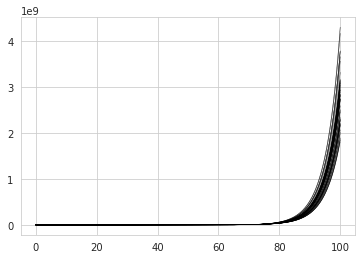

In [12]:
def get_samples_from_dist(
    mu: np.ndarray, sigma: np.ndarray, start: float = 0, end: float = 50, n: int = 50, resolution: int = 400
):
    '''График сэмплированных прямых из распределения параметров'''
    
    xs = np.linspace(start, end, resolution)
    Z = np.random.multivariate_normal(mu, sigma, n)
    samples = np.array([(np.exp(z[0] + z[1] * xs)) for z in Z])
    
    return samples, xs


samples, xs = get_samples_from_dist(mu_posterior, sigma_posterior, end=100)
for sample in samples:
    plt.plot(xs, sample, 'k-', lw=.4)

In [13]:
dates = ['2020-05-01', '2020-06-01', '2020-09-01']
indices = [test[test.date == date].index[0] for date in dates]

samples, xs = get_samples_from_dist(mu_posterior, sigma_posterior, end=indices[-1], n=5000)

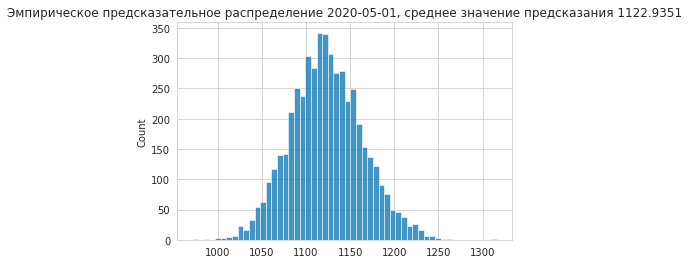

In [14]:
mean = samples[:, indices[0]].mean().round(4)
title = f"Эмпирическое предсказательное распределение {dates[0]}, среднее значение предсказания {mean}"
sns.histplot(samples[:, indices[0]]).set_title(title);

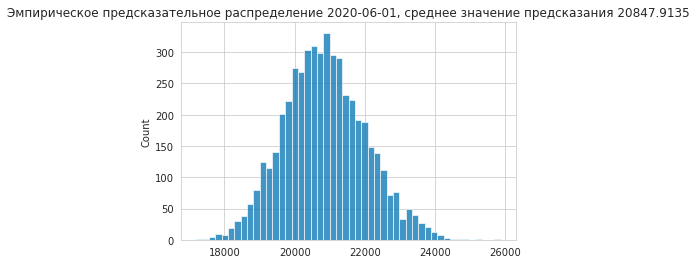

In [15]:
mean = samples[:, indices[1]].mean().round(4)
title = f"Эмпирическое предсказательное распределение {dates[1]}, среднее значение предсказания {mean}"
sns.histplot(samples[:, indices[1]]).set_title(title);

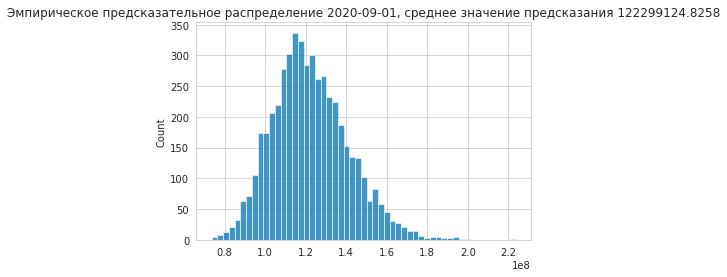

In [16]:
mean = samples[:, indices[2]].mean().round(4)
title = f"Эмпирическое предсказательное распределение {dates[2]}, среднее значение предсказания {mean}"
sns.histplot(samples[:, indices[2]]).set_title(title);

# 3. Сигмоидальная модель

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

$$\Phi(x) = \frac{1}{2\pi} \int_{-\infty}^{x} e^{-t^2 / 2} dt \ \ \ (1)$$

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t

$$total\_cases = С \int_{-\infty}^{x} e^{ \theta_0 + \theta_1 t + \theta_2 t^2} dt \ \ \ (2)$$

## 3.a Описание метода

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Заметим, что приращение количества часла заболевших $\frac{d\ total\_cases}{dx}$ это количество новых случаев $new\_cases$. Продифференцируем и прологарифмируем левую и правую части равенства $(2)$, получим:

$$\ln{new\_cases} = \theta_0 + \theta_1 t + \theta_2 t^2 $$

Тогда для предсказания $total\_cases$ нужно:
1. Обучить линейную регрессию предсказывать логирифм от количества новых случаев
2. Для предсказания общего числа заболевших в определенный день просуммировать экспоненты от полученных предсказаний за все предшествующие дни


## 3.b Линейная регрессия

Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [17]:
train_features = np.hstack((train_features, train_features ** 2))
train_targets = np.log(train.new_cases).values

test_features = np.hstack((test_features, test_features ** 2))
test_targets = np.log(test.new_cases).values

reg = LinearRegression()
reg.fit(train_features, train_targets)

train_pred = reg.predict(train_features)
test_pred = reg.predict(test_features)

In [18]:
mu_prior = np.zeros(3)
sigma_prior = np.diag([10, 10, 10])
mu_posterior, sigma_posterior = bayesian_inference(train_features, train_targets, mu_prior, sigma_prior)

In [19]:
print(reg.intercept_, *reg.coef_)

-0.6721678106280402 0.25854149159458345 -0.0013917790455586902


In [20]:
print(mu_posterior)

[-0.67144807  0.2584827  -0.00139078]


In [21]:
print(sigma_posterior)

[[ 1.03850609e-02 -8.39052079e-04  1.41254384e-05]
 [-8.39052079e-04  9.25402318e-05 -1.76633113e-06]
 [ 1.41254384e-05 -1.76633113e-06  3.60518351e-08]]


## 3.c Предсказание

Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

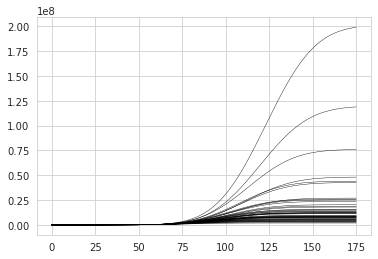

In [22]:
def get_samples_from_dist(
    mu: np.ndarray, sigma: np.ndarray, start: float = 0, end: float = 50, n: int = 50, resolution: int = 400
):
    '''График сэмплированных прямых из распределения параметров'''
    
    xs = np.linspace(start, end, resolution)
    Z = np.random.multivariate_normal(mu, sigma, n)
    samples = np.array([np.cumsum(np.exp(z[0] + z[1] * xs + z[2] * xs ** 2)) for z in Z])
    
    return samples, xs


samples, xs = get_samples_from_dist(mu_posterior, sigma_posterior, end=175)
for sample in samples:
    plt.plot(xs, sample, 'k-', lw=.4)

In [23]:
samples, xs = get_samples_from_dist(mu_posterior, sigma_posterior, end=indices[-1], n=5000)

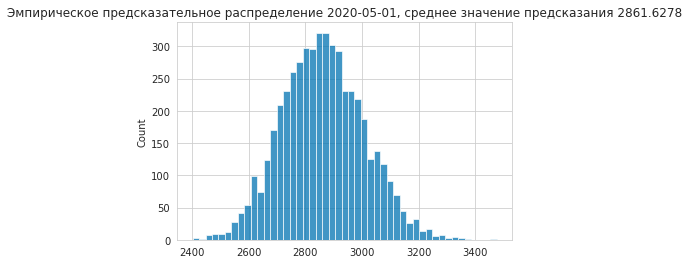

In [24]:
mean = samples[:, indices[0]].mean().round(4)
title = f"Эмпирическое предсказательное распределение {dates[0]}, среднее значение предсказания {mean}"
sns.histplot(samples[:, indices[0]]).set_title(title);

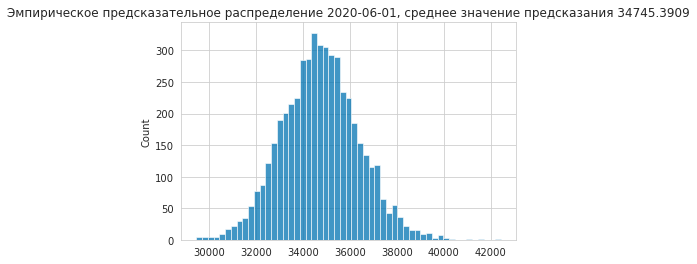

In [25]:
mean = samples[:, indices[1]].mean().round(4)
title = f"Эмпирическое предсказательное распределение {dates[1]}, среднее значение предсказания {mean}"
sns.histplot(samples[:, indices[1]]).set_title(title);

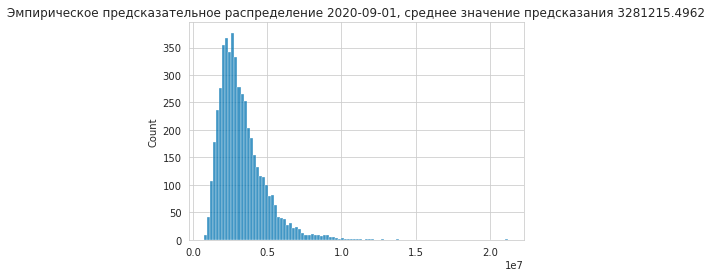

In [26]:
mean = samples[:, indices[2]].mean().round(4)
title = f"Эмпирическое предсказательное распределение {dates[2]}, среднее значение предсказания {mean}"
sns.histplot(samples[:, indices[2]]).set_title(title);

In [27]:
for i in range(len(dates)):
    pessimistic = np.percentile(samples[:, indices[i]], 90, axis=0).round(4)
    optimistic = np.percentile(samples[:, indices[i]], 10, axis=0).round(4)
    print(f"{dates[i]}: пессимистичный прогноз {pessimistic}, оптимистичный прогноз {optimistic}")

2020-05-01: пессимистичный прогноз 3054.401, оптимистичный прогноз 2681.9178
2020-06-01: пессимистичный прогноз 36833.9607, оптимистичный прогноз 32704.3867
2020-09-01: пессимистичный прогноз 5253574.3825, оптимистичный прогноз 1721476.9536
